In [14]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_palette("colorblind")
base_path = Path("results")
plot_path = base_path / "plots"
plot_path.mkdir(exist_ok=True, parents=True)

FONT_SIZE = "xx-large"

In [2]:
app_df = pd.read_parquet(base_path / "application.parquet")
infra_df = pd.read_parquet(base_path / "infrastructure.parquet")
node_df = pd.read_parquet(base_path / "node.parquet")
sim_df = pd.read_parquet(base_path / "simulation.parquet")

In [3]:
dfs = {"application": app_df, "infrastructure": infra_df, "node": node_df, "simulation": sim_df}

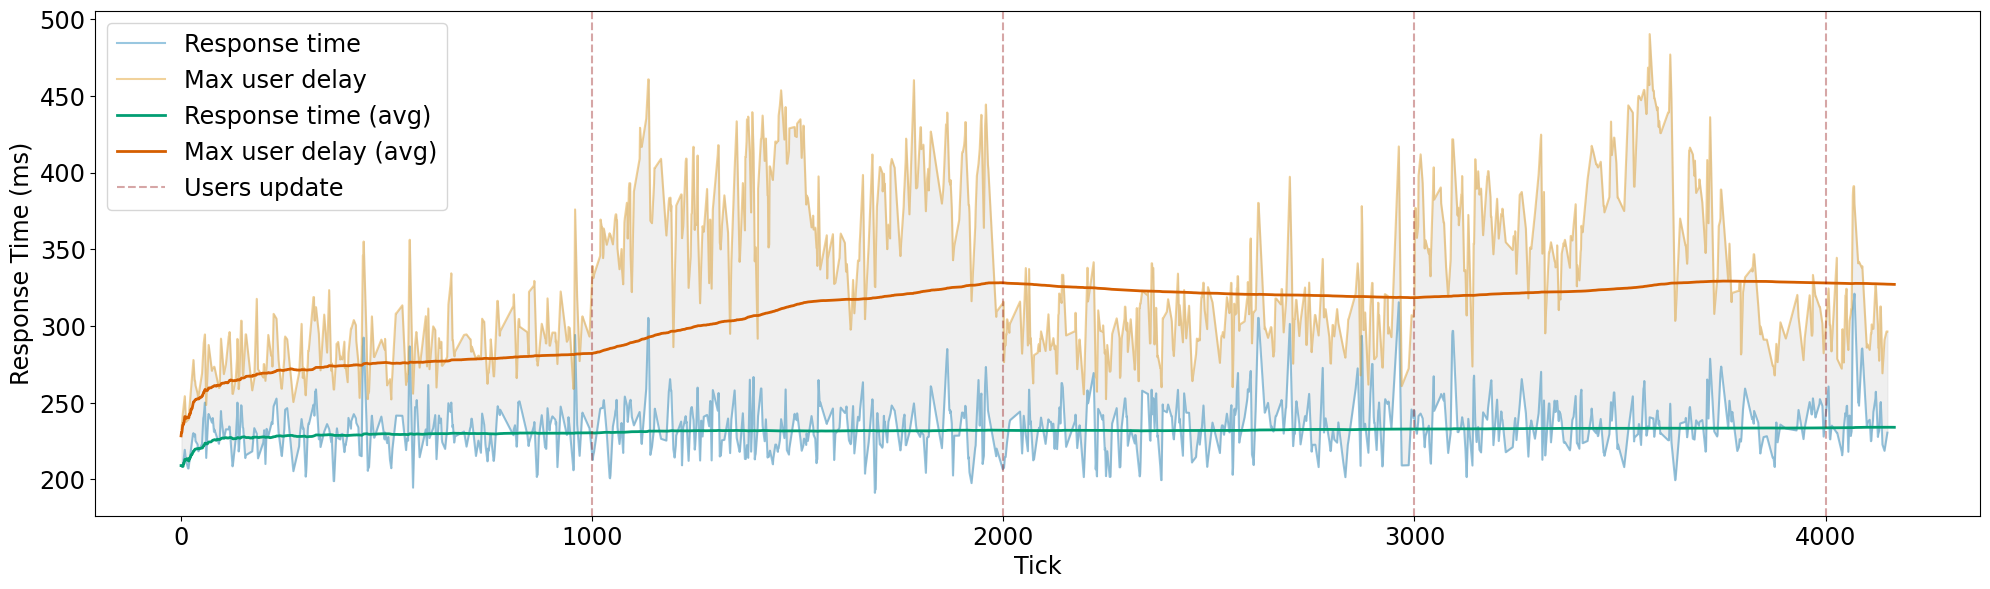

In [6]:
window = 2
lw = 2
alpha = 0.4
new_adf = app_df.copy()
new_idf = infra_df.copy()
new_adf["value"] = new_adf["value"].astype(np.float64)
new_idf["value"] = new_idf["value"].astype(np.float64)

new_adf["smooth"] = new_adf["value"].rolling(window=window).mean()
new_adf["worst"] = (new_adf["value"] + new_idf["value"]).rolling(window=window).max()

new_adf["smooth_avg"] = new_adf["value"].expanding().mean()
new_adf["worst_avg"] = (
    (new_adf["value"] + new_idf["value"]).expanding().mean()
)


plt.figure(figsize=(20, 6))

sns.lineplot(x="n_event", y="smooth", data=new_adf, label="Response time", alpha=alpha)
sns.lineplot(x="n_event", y="worst", data=new_adf, label="Max user delay", alpha=alpha)
sns.lineplot(x="n_event", y="smooth_avg", data=new_adf, lw=lw, label="Response time (avg)")
f = sns.lineplot(x="n_event", y="worst_avg", data=new_adf, lw=lw, label="Max user delay (avg)")


line = f.get_lines()
plt.fill_between(
    line[0].get_xdata(),
    line[0].get_ydata(),
    line[1].get_ydata(),
    color="lightgray",
    alpha=0.35,
)

# vertical line every 1000 ticks
to_label = True
for i in range(1000, new_adf["n_event"].max(), 1000):
    plt.axvline(x=i, color="darkred", linestyle="--", alpha=0.35, label="Users update" if to_label else None)
    to_label = False

plt.xlabel("Tick", fontsize=FONT_SIZE)
plt.ylabel("Response Time (ms)", fontsize=FONT_SIZE)
plt.tick_params(axis="both", which="major", labelsize=FONT_SIZE)

plt.legend(fontsize=FONT_SIZE, loc="upper left")
plt.tight_layout()
plt.savefig(plot_path / "response_time_variation.pdf", dpi=600, format="pdf")
plt.show()

In [4]:
start_tick = 40
w = 100
sim_df = sim_df.astype({"n_event": np.int32, "value": np.int32})

df_cpu = sim_df[(sim_df["callback_id"] == "cpu_usage")].copy()
df_cpu["avg"] = df_cpu["value"].rolling(window=w).mean()
df_cpu["smooth"] = df_cpu["value"].expanding().mean()

df_mem = sim_df[(sim_df["callback_id"] == "memory_usage") & (sim_df["event_id"] != "stop")].copy()
df_mem["fluctuation"] = (df_mem["value"].diff().abs() / df_mem["value"].shift(1)) * 100

df_cpu = df_cpu[df_cpu["n_event"] > start_tick]
df_mem = df_mem[df_mem["n_event"] > start_tick]

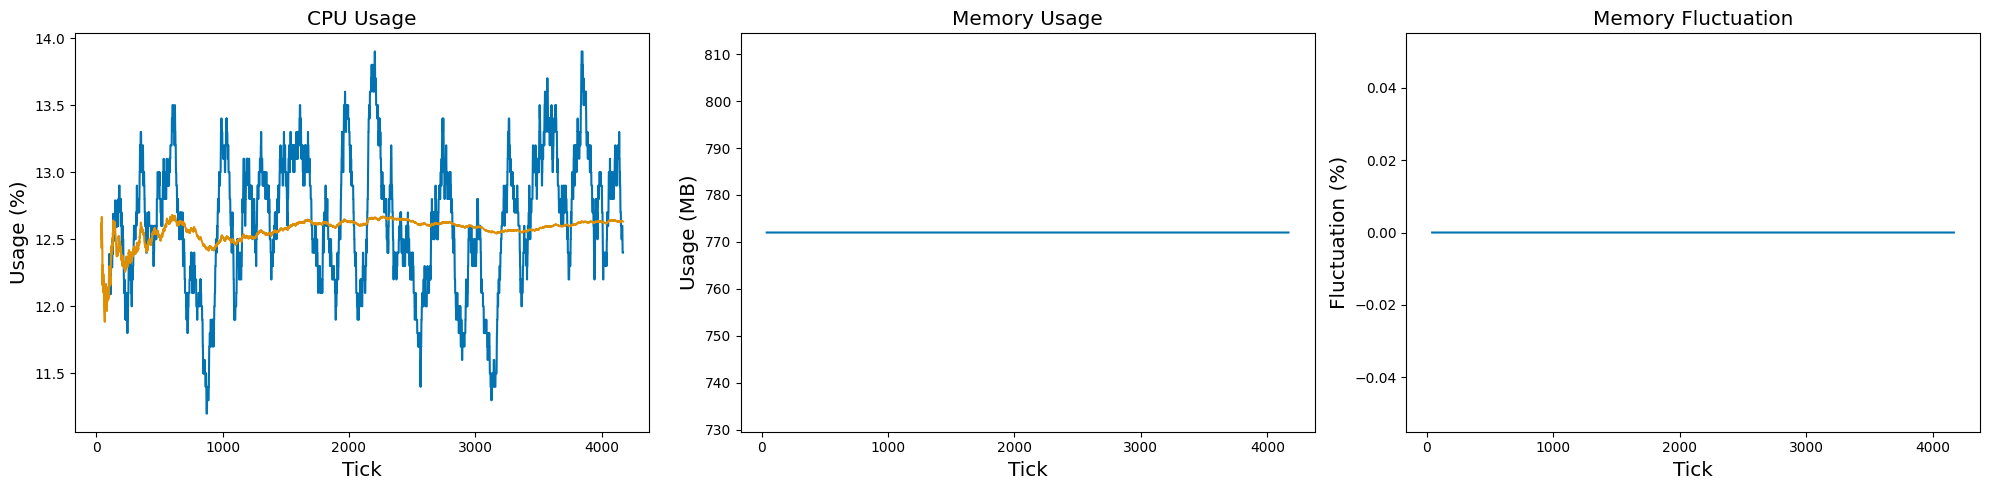

In [5]:
_, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(data=df_cpu, x="n_event", y="avg", ax=axes[0])
sns.lineplot(data=df_cpu, x="n_event", y="smooth", ax=axes[0])

axes[0].set_title("CPU Usage", fontsize=FONT_SIZE)
axes[0].set_xlabel("Tick", fontsize=FONT_SIZE)
axes[0].set_ylabel("Usage (%)", fontsize=FONT_SIZE)

sns.lineplot(data=df_mem, x="n_event", y="value", ax=axes[1])

axes[1].set_title("Memory Usage", fontsize=FONT_SIZE)
axes[1].set_xlabel("Tick", fontsize=FONT_SIZE)
axes[1].set_ylabel("Usage (MB)", fontsize=FONT_SIZE)

sns.lineplot(data=df_mem, x="n_event", y="fluctuation", ax=axes[2])

axes[2].set_title("Memory Fluctuation", fontsize=FONT_SIZE)
axes[2].set_xlabel("Tick", fontsize=FONT_SIZE)
axes[2].set_ylabel("Fluctuation (%)", fontsize=FONT_SIZE)

plt.tight_layout()
plt.savefig(plot_path / "resource_usage.pdf", dpi=600, format="pdf")
plt.show()

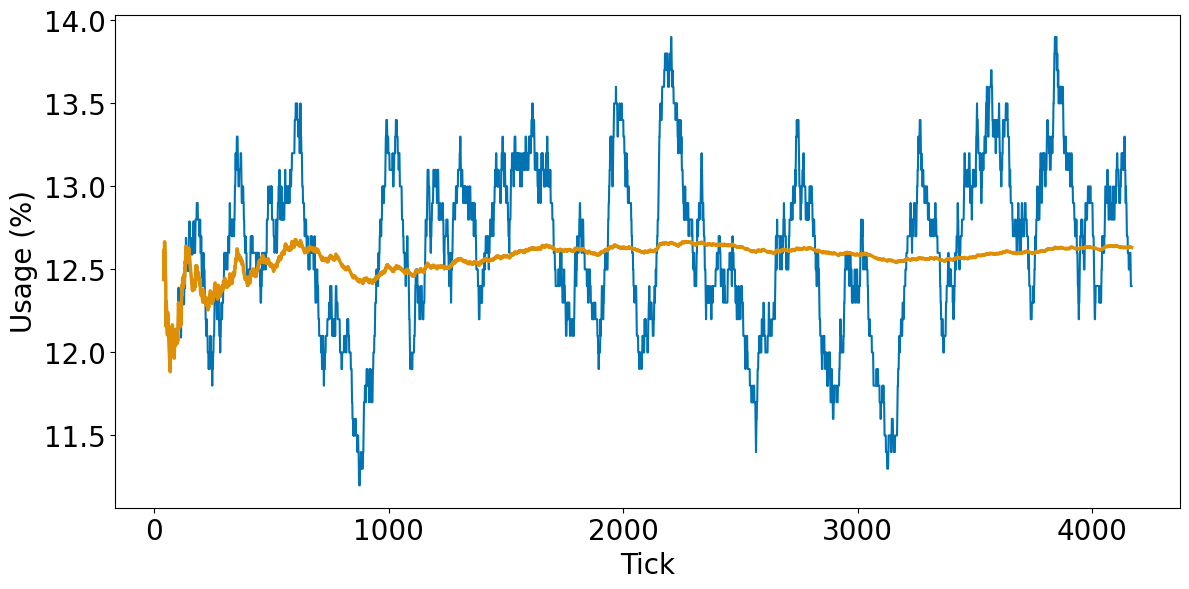

In [16]:
FONT_SIZE_XL = 20
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cpu, x="n_event", y="avg")
sns.lineplot(data=df_cpu, x="n_event", y="smooth", linewidth=2.5)

# plt.title("CPU Usage", fontsize=fontsize)
plt.xlabel("Tick", fontsize=FONT_SIZE_XL)
plt.ylabel("Usage (%)", fontsize=FONT_SIZE_XL)
plt.tick_params(axis="both", which="major", labelsize=FONT_SIZE_XL)
plt.tight_layout()
plt.savefig(plot_path / "cpu_usage.pdf", dpi=600, format="pdf")
plt.show()